In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import argparse
import os
import pprint
import json
import time

import torch
import torch.backends.cudnn as cudnn
import torch.nn.parallel
import torch.optim
import torch.utils.data
import time
import torch.utils.data.distributed
import torchvision.transforms
import matplotlib.pyplot as plt
import torch.multiprocessing
from tqdm import tqdm

import _init_paths
import models
from dataset.InferenceDataset import *
from models.pose_simplenet import *
import torchvision
import torch
from config import cfg
from config import check_config
from config import update_config
from core.inference import get_multi_stage_outputs
from core.inference import aggregate_results
from core.group import HeatmapParser
from dataset import make_test_dataloader, make_train_dataloader
from fp16_utils.fp16util import network_to_half
from utils.utils import create_logger
from utils.utils import get_model_summary
from utils.vis import save_debug_images
from utils.vis import save_valid_image
from utils.transforms import resize_align_multi_scale
from utils.transforms import get_final_preds
from utils.transforms import get_multi_scale_size
from arch_manager import ArchManager

/usr/local/lib/python3.8/dist-packages/torchvision-0.13.1a0+bddbd7e-py3.8-linux-x86_64.egg/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /usr/local/lib/python3.8/dist-packages/torchvision-0.13.1a0+bddbd7e-py3.8-linux-x86_64.egg/torchvision/image.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE
  warn(f"Failed to load image Python extension: {e}")


In [2]:
parser = argparse.ArgumentParser()
parser.add_argument('--cfg',
                    help='experiment configure file name',
                    required=True,
                    type=str)

parser.add_argument('opts',
                    help="Modify config options using the command-line",
                    default=None,
                    nargs=argparse.REMAINDER)

#fixed config for supernet
parser.add_argument('--superconfig',
                    default=None,
                    type=str,
                    help='fixed arch for supernet training')
args = parser.parse_args("--cfg experiments/crowd_pose/mobilenet/mobile.yaml --superconfig mobile_configs/search-S.json TEST.MODEL_FILE LitePose-Auto-S.tar".split(" "))
update_config(cfg, args)
check_config(cfg)

# change the resolution according to config
fixed_arch = None
if args.superconfig is not None:
    with open(args.superconfig, 'r') as f:
       fixed_arch = json.load(f)
    cfg.defrost()
    reso = fixed_arch['img_size']
    cfg.DATASET.INPUT_SIZE = reso
    cfg.DATASET.OUTPUT_SIZE = [reso // 4, reso // 2]
    cfg.freeze()

logger, final_output_dir, tb_log_dir = create_logger(
    cfg, args.cfg, 'valid'
)

logger.info(pprint.pformat(args))
logger.info(cfg)

# cudnn related setting
cudnn.benchmark = cfg.CUDNN.BENCHMARK
torch.backends.cudnn.deterministic = cfg.CUDNN.DETERMINISTIC
torch.backends.cudnn.enabled = cfg.CUDNN.ENABLED

if cfg.MODEL.NAME == 'pose_mobilenet' or cfg.MODEL.NAME == 'pose_simplenet':
    arch_manager = ArchManager(cfg)
    cfg_arch = arch_manager.fixed_sample()
    if fixed_arch is not None:
        cfg_arch = fixed_arch
    model = eval('models.'+cfg.MODEL.NAME+'.get_pose_net')(
        cfg, is_train=True, cfg_arch = cfg_arch
    )
else:
    model = eval('models.'+cfg.MODEL.NAME+'.get_pose_net')(
        cfg, is_train=True
    )

#set super config
if cfg.MODEL.NAME == 'pose_supermobilenet':
    model.arch_manager.is_search = True
    if args.superconfig is not None:
        with open(args.superconfig, 'r') as f:
            model.arch_manager.search_arch = json.load(f)
    else:
        model.arch_manager.search_arch = model.arch_manager.fixed_sample()

dump_input = torch.rand(
    (1, 3, cfg.DATASET.INPUT_SIZE, cfg.DATASET.INPUT_SIZE)
)
logger.info(get_model_summary(cfg.DATASET.INPUT_SIZE, model, dump_input))

if cfg.TEST.MODEL_FILE:
    logger.info('=> loading model from {}'.format(cfg.TEST.MODEL_FILE))
    model.load_state_dict(torch.load(cfg.TEST.MODEL_FILE), strict=True)
else:
    model_state_file = os.path.join(
        final_output_dir, 'model_best.pth.tar'
    )
    logger.info('=> loading model from {}'.format(model_state_file))
    model.load_state_dict(torch.load(model_state_file))
    
# if cfg.FP16.ENABLED:
#     print("Using half precision.")
#     model = network_to_half(model)

model = torch.nn.DataParallel(model, device_ids=cfg.GPUS).cuda()

transforms = torchvision.transforms.Compose(
            [
                torchvision.transforms.ToTensor(),
                torchvision.transforms.Normalize(
                    mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225]
                )
            ]
        )

dataset = InferenceDataset(root="/mnt/hdd/data/pose_testing")

data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=1,
    shuffle=False,
    num_workers=0,
    pin_memory=False
)

parser = HeatmapParser(cfg)
all_preds = []
all_scores = []
all_images = []
all_outputs = []

pbar = tqdm(total=len(dataset)) if cfg.TEST.LOG_PROGRESS else None
#eval mode
model.eval()
count = 0
t = 0
for j in range(1):
    for i, images in enumerate(data_loader):
        assert 1 == images.size(0), 'Test batch size should be 1'
        image = images[0].cpu().numpy()
        # size at scale 1.0
        base_size, center, scale = get_multi_scale_size(
            image, cfg.DATASET.INPUT_SIZE, 1.0, min(cfg.TEST.SCALE_FACTOR)
        )

        with torch.no_grad():
            # infer_begin = time.time()
            final_heatmaps = None
            tags_list = []
            for idx, s in enumerate(sorted(cfg.TEST.SCALE_FACTOR, reverse=True)):
                input_size = cfg.DATASET.INPUT_SIZE
                image_resized, center, scale = resize_align_multi_scale(
                    image, input_size, s, min(cfg.TEST.SCALE_FACTOR)
                )
                # print(image_resized.shape)
                
                image_resized = transforms(image_resized)
                image_resized = image_resized.unsqueeze(0).cuda()
                
                # start_time = time.time()

                outputs, heatmaps, tags, tt = get_multi_stage_outputs(
                    cfg, model, image_resized, cfg.TEST.FLIP_TEST,
                    cfg.TEST.PROJECT2IMAGE,base_size
                )
                
                # end_time = time.time()

                final_heatmaps, tags_list = aggregate_results(
                    cfg, s, final_heatmaps, tags_list, heatmaps, tags
                )

            final_heatmaps = final_heatmaps / float(len(cfg.TEST.SCALE_FACTOR))
            tags = torch.cat(tags_list, dim=4)
            grouped, scores = parser.parse(
                final_heatmaps, tags, cfg.TEST.ADJUST, cfg.TEST.REFINE
            )
            final_results = get_final_preds(
                grouped, center, scale,
                [final_heatmaps.size(3), final_heatmaps.size(2)]
            )

            t += tt
            count += 1

        all_preds.append(final_results)
        all_scores.append(scores)
        all_images.append(image)
        all_outputs.append(outputs)

print(t/count)

if cfg.TEST.LOG_PROGRESS:
    pbar.close()

Namespace(cfg='experiments/crowd_pose/mobilenet/mobile.yaml', opts=['TEST.MODEL_FILE', 'LitePose-Auto-S.tar'], superconfig='mobile_configs/search-S.json')
AUTO_RESUME: True
CUDNN:
  BENCHMARK: True
  DETERMINISTIC: False
  ENABLED: True
DATASET:
  BASE_SIGMA: 2.0
  BASE_SIZE: 256.0
  DATASET: crowd_pose_kpt
  DATASET_TEST: crowd_pose
  DATA_FORMAT: jpg
  FLIP: 0.5
  INPUT_SIZE: 448
  INT_SIGMA: False
  MAX_NUM_PEOPLE: 30
  MAX_ROTATION: 30
  MAX_SCALE: 1.5
  MAX_TRANSLATE: 40
  MIN_SCALE: 0.75
  NUM_JOINTS: 14
  OUTPUT_SIZE: [112, 224]
  ROOT: /dataset/crowdpose
  SCALE_AWARE_SIGMA: False
  SCALE_TYPE: short
  SIGMA: 2
  TEST: test
  TRAIN: trainval
  WITH_CENTER: False
DATA_DIR: 
DEBUG:
  DEBUG: True
  SAVE_BATCH_IMAGES_GT: False
  SAVE_BATCH_IMAGES_PRED: False
  SAVE_HEATMAPS_GT: True
  SAVE_HEATMAPS_PRED: True
  SAVE_TAGMAPS_PRED: True
DIST_BACKEND: nccl
FP16:
  DYNAMIC_LOSS_SCALE: False
  ENABLED: True
  STATIC_LOSS_SCALE: 1.0
GPUS: (0,)
LOG_DIR: log
LOSS:
  AE_LOSS_TYPE: exp
  HEA

=> creating output/crowd_pose_kpt/pose_mobilenet/mobile
=> creating log/crowd_pose_kpt/pose_mobilenet/mobile_2022-11-22-16-29




Total Parameters: 2.73 M
----------------------------------------------------------------------------------------------------------------------------------
Total Multiply Adds: 4.98 GMac
----------------------------------------------------------------------------------------------------------------------------------
Number of Layers

=> loading model from LitePose-Auto-S.tar


In [ ]:
plt.imshow(all_outputs[3][0][0, 10].cpu().numpy())
plt.colorbar()

IndexError: list index out of range

17
0.06934104
0 574.93304 230.4241 0.45085514 6.11451
0 549.21875 169.75447 0.6136942 0.0
0 524.70984 256.94196 0.75277203 0.0
0 502.2098 192.25447 0.5225877 0.0
0 480.1116 224.7991 0.39283425 0.0
0 456.80804 201.49553 0.31865558 0.0
0 530.7366 283.8616 0.47720388 0.0
0 503.81696 262.56696 0.3215066 0.0
0 595.4241 148.8616 0.5199194 6.10202
0 568.90625 190.64732 0.71769816 0.0
0.0438353
1 574.93304 230.4241 0.45085514 0.0
1 549.21875 169.75447 0.6136942 6.297834
1 524.70984 256.94196 0.75277203 0.0
1 502.2098 192.25447 0.5225877 0.0
1 479.7098 228.0134 0.4725442 0.0
1 456.80804 201.49553 0.31865558 0.0
1 530.7366 283.8616 0.47720388 0.0
1 503.81696 262.56696 0.3215066 0.0
1 595.4241 148.8616 0.5199194 0.0
1 568.90625 190.64732 0.71769816 0.0
0.053769432
2 574.93304 230.4241 0.45085514 0.0
2 549.21875 169.75447 0.6136942 0.0
2 524.70984 256.94196 0.75277203 6.437478
2 502.2098 192.25447 0.5225877 0.0
2 479.7098 228.0134 0.4725442 0.0
2 456.80804 201.49553 0.31865558 0.0
2 530.7366 283.8

IndexError: list index out of range

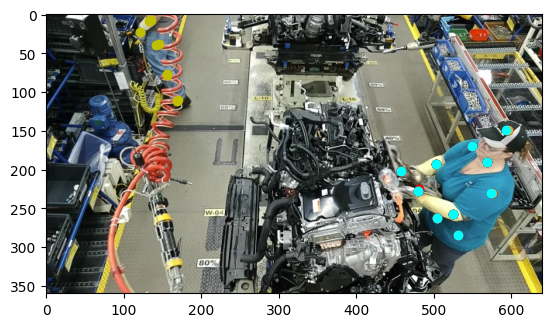

In [77]:
k = 1
preds = all_preds[k]
scores = all_scores[k]
print(len(preds))
image = all_images[k]
plt.imshow(image)
colors = ['r', 'g', 'b', 'y', 'orange', 'purple', 'cyan']
for j in range(len(preds)):
    if (preds[j][:, 2] > 0.1).sum() > 0:
        print(scores[j])
        for i in range(preds[j].shape[0]):
            if preds[j][i, 2] > 0.1 and scores[j] > 0.01:
                print(j, preds[j][i, 0], preds[j][i, 1], preds[j][i, 2], preds[j][i, 3])
                plt.scatter([preds[j][i, 0]], [preds[j][i, 1]], c=colors[j])

In [29]:
model

DataParallel(
  (module): Sequential(
    (0): tofp16()
    (1): LitePose(
      (first): Sequential(
        (0): convbnrelu(
          (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): convbnrelu(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (2): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (stage): ModuleList(
        (0): Sequential(
          (0): InvBottleneck(
            (inv): Sequential(
              (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
  